In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi

In [175]:
df = pd.read_csv('LeagueData.csv')

C:\Users\Rajee\AppData\Local\Temp\ipykernel_36184\2560409737.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('LeagueData.csv')


In [176]:
df = df[df['league'].isin(['MSI', 'EWC'])]


In [177]:
df.columns.tolist()

['gameid',
 'datacompleteness',
 'url',
 'league',
 'year',
 'split',
 'playoffs',
 'date',
 'game',
 'patch',
 'participantid',
 'side',
 'position',
 'playername',
 'playerid',
 'teamname',
 'teamid',
 'champion',
 'ban1',
 'ban2',
 'ban3',
 'ban4',
 'ban5',
 'pick1',
 'pick2',
 'pick3',
 'pick4',
 'pick5',
 'gamelength',
 'result',
 'kills',
 'deaths',
 'assists',
 'teamkills',
 'teamdeaths',
 'doublekills',
 'triplekills',
 'quadrakills',
 'pentakills',
 'firstblood',
 'firstbloodkill',
 'firstbloodassist',
 'firstbloodvictim',
 'team kpm',
 'ckpm',
 'firstdragon',
 'dragons',
 'opp_dragons',
 'elementaldrakes',
 'opp_elementaldrakes',
 'infernals',
 'mountains',
 'clouds',
 'oceans',
 'chemtechs',
 'hextechs',
 'dragons (type unknown)',
 'elders',
 'opp_elders',
 'firstherald',
 'heralds',
 'opp_heralds',
 'void_grubs',
 'opp_void_grubs',
 'firstbaron',
 'barons',
 'opp_barons',
 'atakhans',
 'opp_atakhans',
 'firsttower',
 'towers',
 'opp_towers',
 'firstmidtower',
 'firsttothree

In [ ]:
df["kda"] = (df["kills"] + df["assists"]) / df["deaths"].replace(0, np.nan)
if "damageshare" in df.columns:
    df["dmg_pct"] = df["damageshare"] * 100
else:
    df["dmg_pct"] = np.nan

stats_cols = [
    "dpm",
    "cspm",
    "earned gpm",
    "golddiffat15",
    "csdiffat15",
    "xpdiffat15",
    "kda",
    "dmg_pct"
    ]
labels = [
    "DPM",
    "CSM",
    "GPM",
    "GD@15",
    "CSD@15",
    "XPD@15",
    "KDA",
    "DMG%"
    ]

In [179]:
print("Available columns:", [col for col in stats_cols if col in df.columns])


Available columns: ['dpm', 'cspm', 'earned gpm', 'golddiffat15', 'csdiffat15', 'xpdiffat15', 'kda', 'dmg_pct']


In [180]:
player_stats = df.groupby(["playername", "teamname", "position"])[stats_cols].mean().reset_index()

In [ ]:

role_avg = player_stats.groupby('position')[stats_cols].mean()

stat_mins = player_stats[stats_cols].min()
stat_maxs = player_stats[stats_cols].max()

In [ ]:
def make_radar(ax, values, role, categories, label, raw_values=None, color="orange", avg_color="red"):
    avg_values = role_avg.loc[role].values
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    avg_normed = (avg_values - stat_mins) / (stat_maxs - stat_mins) 
    vals = np.concatenate([np.array(values), [values[0]]])
    avg_vals = np.concatenate([np.array(avg_normed), [avg_normed[0]]])
    
    ax.plot(angles, vals, color=color, linewidth=2)
    ax.fill(angles, vals, color=color, alpha=0.25)

    ax.plot(angles, avg_vals, color=avg_color, linewidth=2, linestyle="dashed")

    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])

    if raw_values is not None:
        tick_labels = [f"{cat}\n{val:.1f}" for cat, val in zip(categories, raw_values)]
    else:
        tick_labels = categories
    ax.set_xticklabels(tick_labels, size=9)

    ax.set_yticklabels([])
    ax.set_title(label, size=12, pad=10, color="white")
    ax.grid(color="#555555") 
    ax.spines["polar"].set_color("#555555")  
    ax.tick_params(colors='white')

    ax.set_xticklabels(tick_labels, size=9, color="white")

    for lbl in ax.get_xticklabels():
        lbl.set_horizontalalignment("center")
        lbl.set_verticalalignment("center")
        lbl.set_y(lbl.get_position()[1] - 0.075)



In [ ]:
def plot_role_radars(role="mid", max_players=6,
    theme={"bg_color": "white", "text_color": "black", "player_color": "orange", "avg_color": "red"}):

    data = player_stats[player_stats["position"] == role]

    normed = (data[stats_cols] - stat_mins) / (stat_maxs - stat_mins)
    avg_normed = (league_avg - stat_mins) / (stat_maxs - stat_mins)

    normed["score"] = normed.mean(axis=1)
    data = data.assign(score=normed["score"]).sort_values("score", ascending=False).head(max_players)
    normed = normed.loc[data.index] 
    n = len(data)
    cols = 3
    rows = int(np.ceil(n / cols))

    fig, axes = plt.subplots(rows, cols, subplot_kw=dict(polar=True), figsize=(cols*5, rows*5))
    axes = axes.flatten()

    fig.patch.set_facecolor(theme["bg_color"])


    for i, (idx, row) in enumerate(data.iterrows()):
        player_values = normed.loc[idx, stats_cols].values
        avg_values = avg_normed.values
        raw_values = row[stats_cols].values  
        display_name = f"{row['playername']} ({row['teamname']})"
        make_radar(
            axes[i],
            player_values,
            role,        
            labels,
            label=display_name,
            raw_values=raw_values,
            color=theme["player_color"],
            avg_color=theme["avg_color"]
            )



    for j in range(i+1, len(axes)):
        axes[j].set_axis_off()

    plt.suptitle(role.upper(), size=20, color=theme["text_color"])
    plt.tight_layout()
    plt.show()


In [184]:
print(df["damageshare"].head())
print(df["dmg_pct"].head())
print(df.columns)

74712    0.258125
74713    0.240792
74714    0.236016
74715    0.180018
74716    0.085050
Name: damageshare, dtype: float64
74712    25.81250
74713    24.07920
74714    23.60160
74715    18.00180
74716     8.50499
Name: dmg_pct, dtype: float64
Index(['gameid', 'datacompleteness', 'url', 'league', 'year', 'split',
       'playoffs', 'date', 'game', 'patch',
       ...
       'xpdiffat25', 'csdiffat25', 'killsat25', 'assistsat25', 'deathsat25',
       'opp_killsat25', 'opp_assistsat25', 'opp_deathsat25', 'kda', 'dmg_pct'],
      dtype='object', length=166)


In [ ]:
dark_theme = {
    "bg_color": "#262626",   
    "text_color": "#e0e0e0",   
    "player_color": "#00c2ff", 
    "avg_color": "#FF0000"      
}


C:\Users\Rajee\AppData\Local\Temp\ipykernel_36184\282642573.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  avg_vals = np.concatenate([np.array(avg_normed), [avg_normed[0]]])
C:\Users\Rajee\AppData\Local\Temp\ipykernel_36184\282642573.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  avg_vals = np.concatenate([np.array(avg_normed), [avg_normed[0]]])
C:\Users\Rajee\AppData\Local\Temp\ipykernel_36184\282642573.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a valu

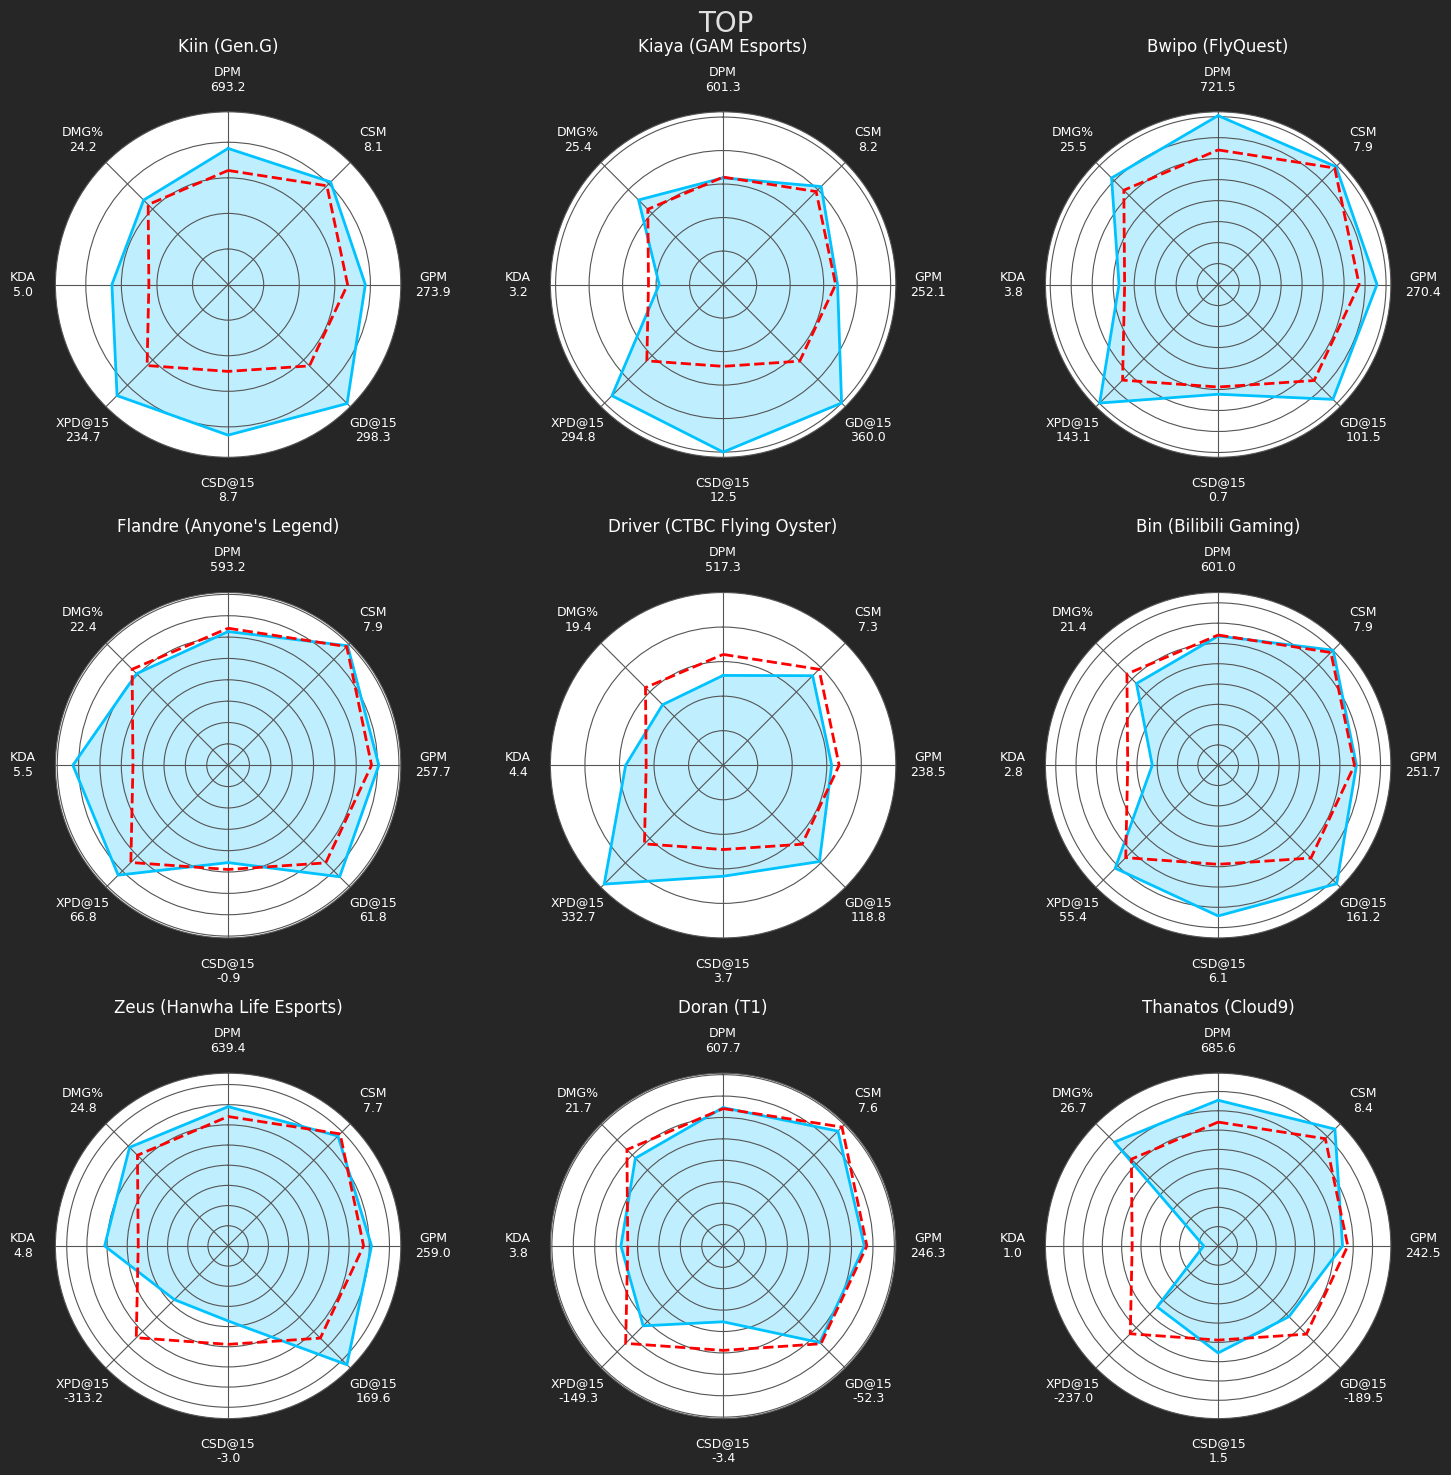

In [186]:
plot_role_radars("top", max_players=9, theme=dark_theme)

C:\Users\Rajee\AppData\Local\Temp\ipykernel_36184\282642573.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  avg_vals = np.concatenate([np.array(avg_normed), [avg_normed[0]]])
C:\Users\Rajee\AppData\Local\Temp\ipykernel_36184\282642573.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  avg_vals = np.concatenate([np.array(avg_normed), [avg_normed[0]]])
C:\Users\Rajee\AppData\Local\Temp\ipykernel_36184\282642573.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a valu

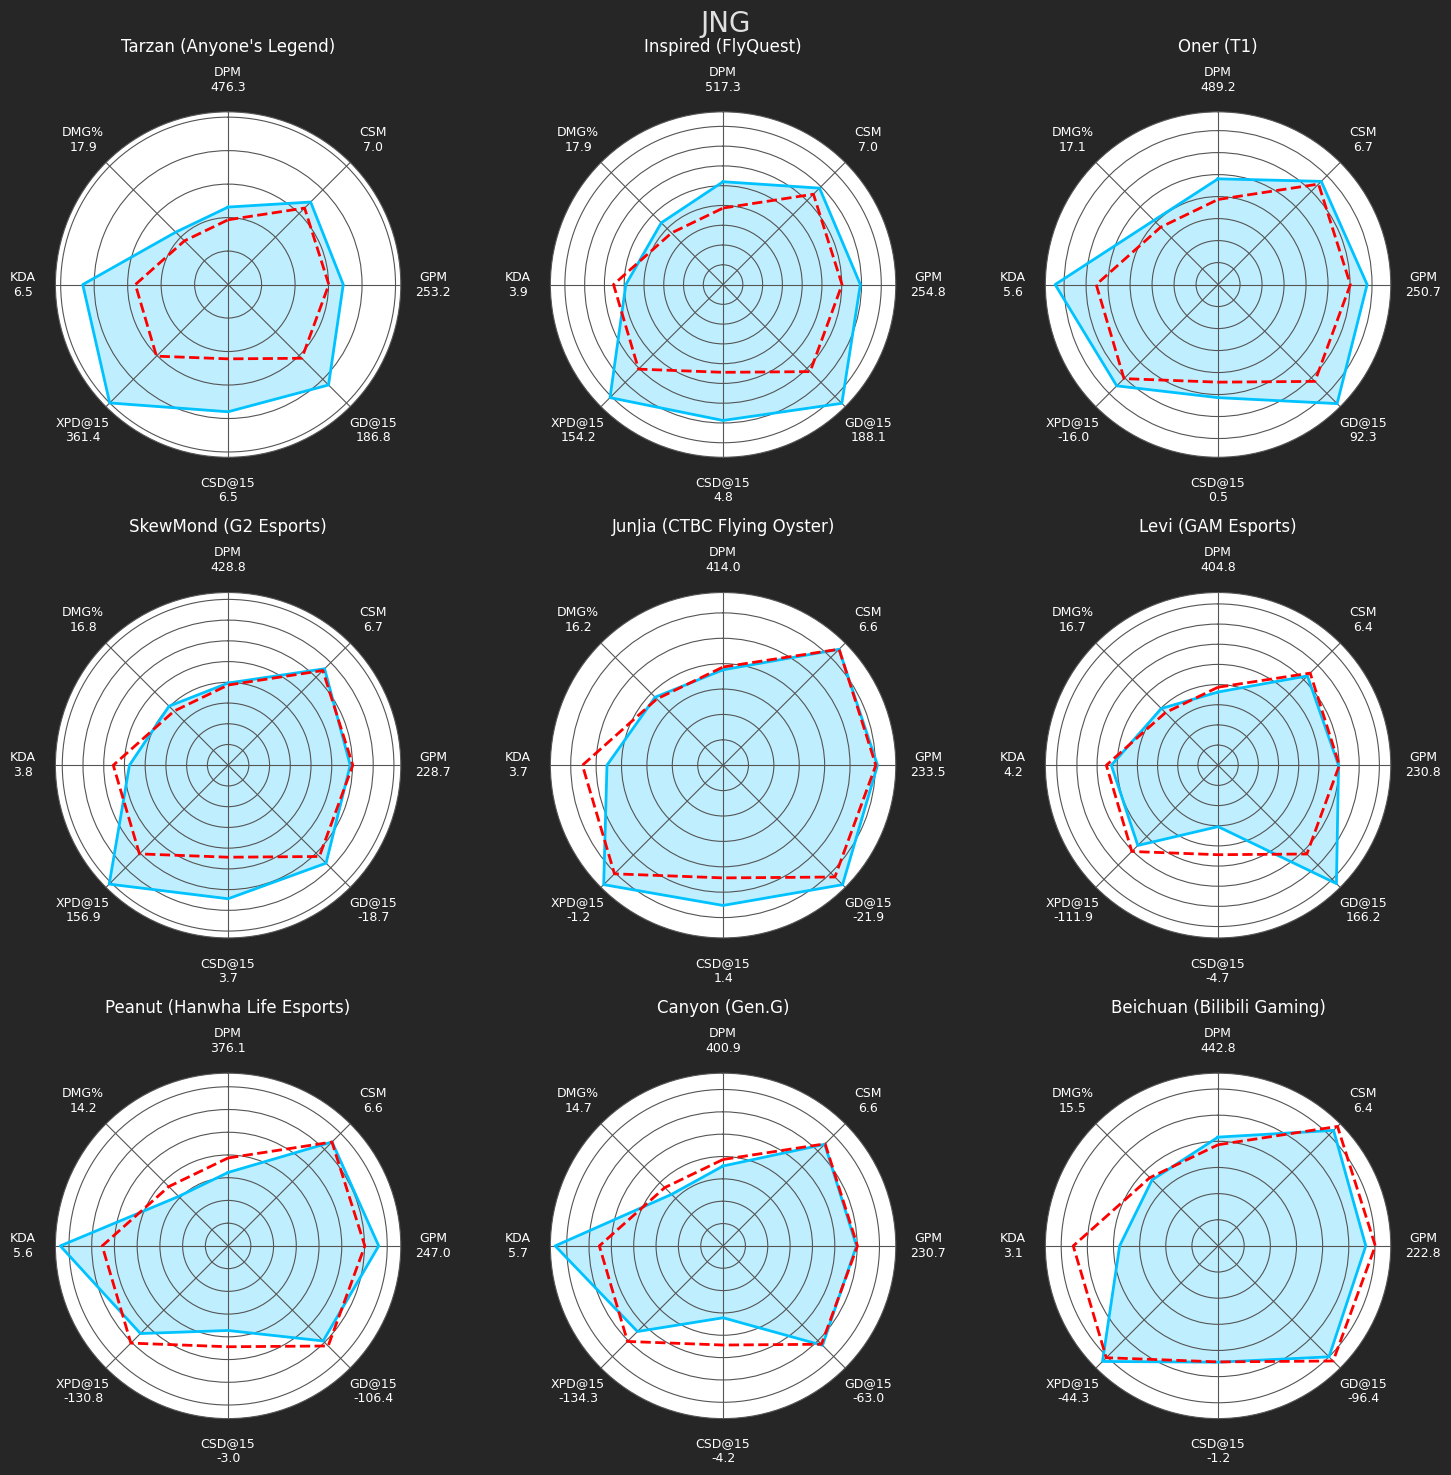

In [187]:
plot_role_radars("jng", max_players=9, theme=dark_theme)

C:\Users\Rajee\AppData\Local\Temp\ipykernel_36184\282642573.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  avg_vals = np.concatenate([np.array(avg_normed), [avg_normed[0]]])
C:\Users\Rajee\AppData\Local\Temp\ipykernel_36184\282642573.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  avg_vals = np.concatenate([np.array(avg_normed), [avg_normed[0]]])
C:\Users\Rajee\AppData\Local\Temp\ipykernel_36184\282642573.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a valu

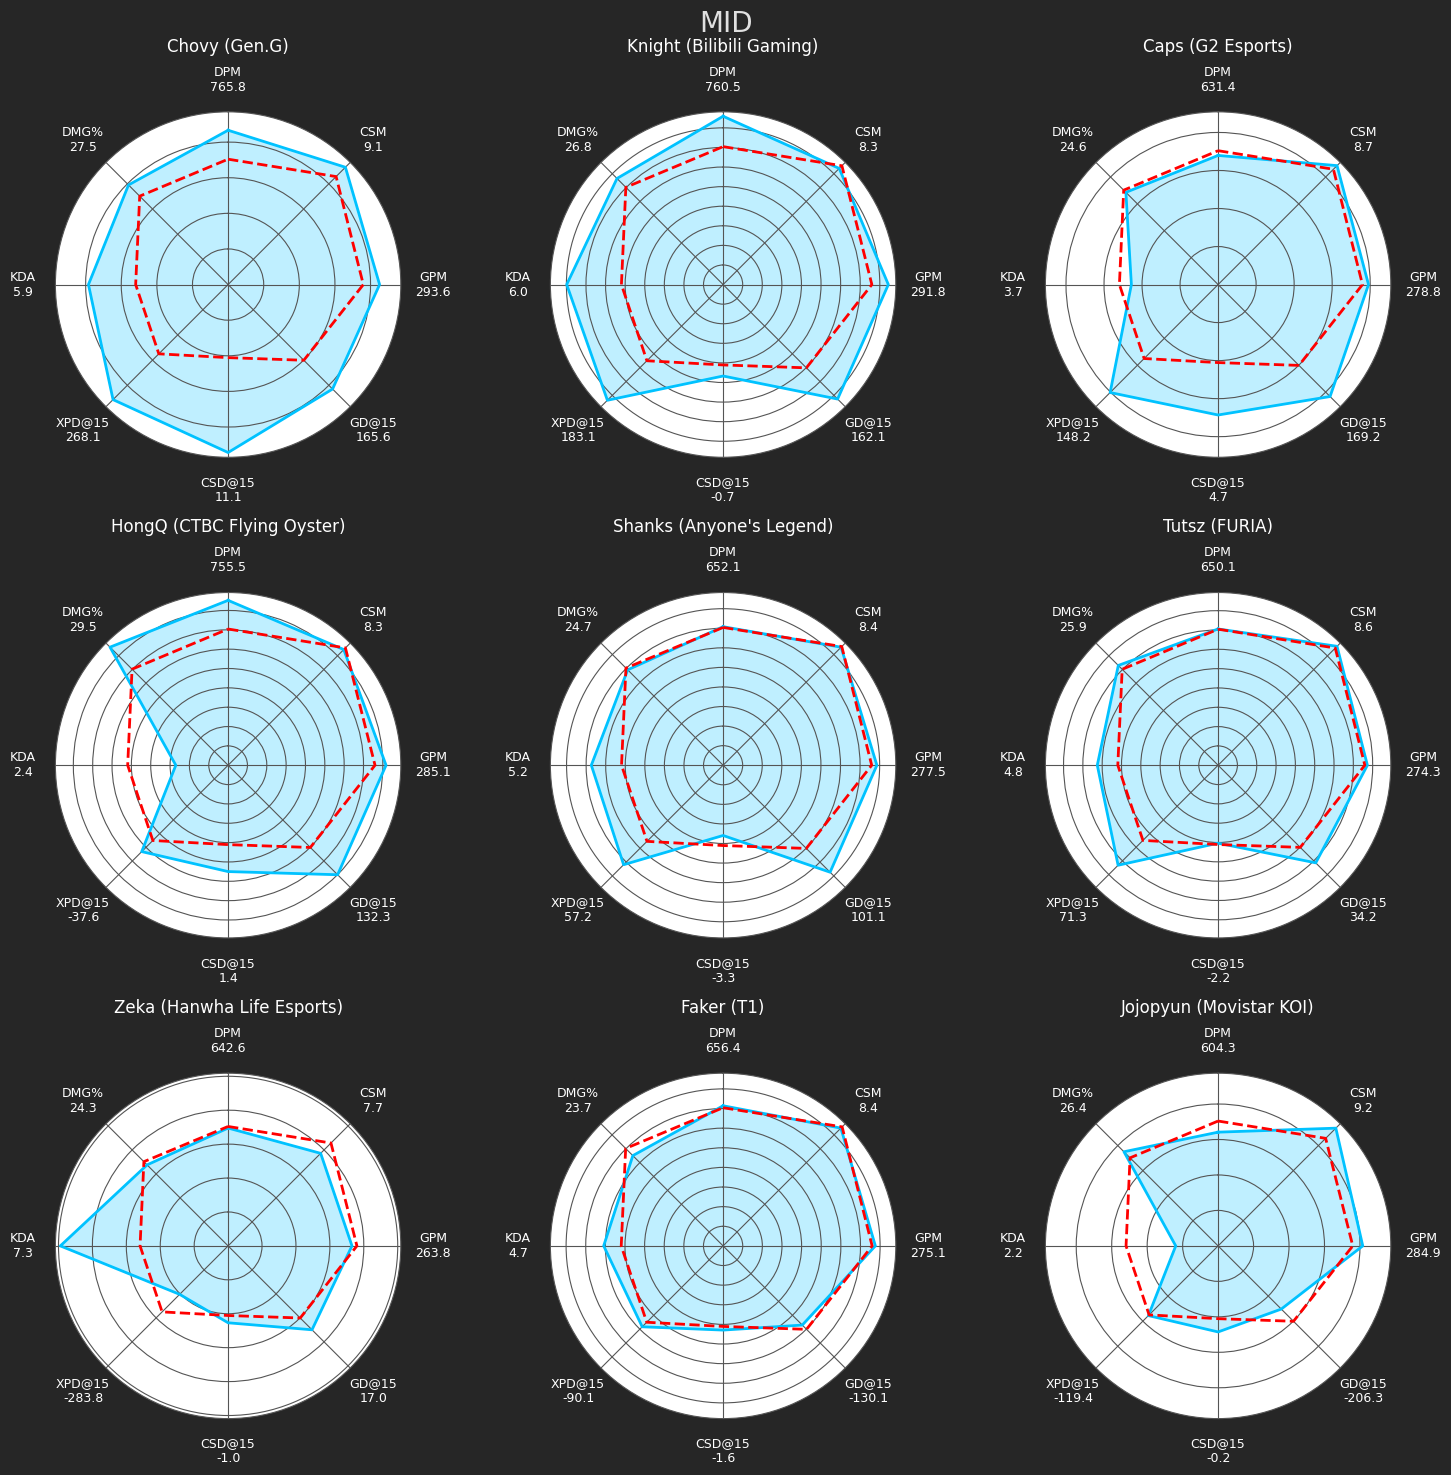

In [188]:
plot_role_radars("mid", max_players=9, theme=dark_theme)